<a href="https://colab.research.google.com/github/kaidrumm/Article-Similarity-with-Latent-Semantic-Indexing/blob/main/DocumentWordMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import os
import re
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.linalg import lu

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Example from Stanford online textbook (Manning)
# nlp.stanford.edu/IR-book/html/htmledition/latent-semantic-indexing-1.html
C = [[1,0,1,0,0,0],[0,1,0,0,0,0],[1,1,0,0,0,0],[1,0,0,1,1,0],[0,0,0,1,0,1]]

# Round numbers when printing
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

# Factor the original matrix
u, s, vh = np.linalg.svd(C)
print("\nMatrix U:\n",u)
print("\nSingular values:\n",s)
print("\nMatrix V^T:\n",vh)

# Store sigma as diagonal matrix
sigma = np.diag(s)

# Store vT as v
# Delete column associated with 0 singular value
v = np.transpose(vh[:-1, :])

# Reconstitute C2
C2 = u @ sigma @ np.transpose(v)
print("\nOriginal matrix recreated from factors\n", C2)

# Zeroing out sigma
sigma[2:] = 0
print("\nSigma zeroed to 2 components:\n", sigma)
C3 = sigma @ np.transpose(v)
print("\nC2 is U times truncated sigma\n", C3)

# # Truncate matrices
uprime = u[:, :2]
sprime = sigma[:2, :2]
vprime = v[:, :2]
print("\n U truncated:\n", uprime)
print("\nSigma truncated:\n", sprime)
print("\nVT truncated:\n", np.transpose(vprime))

# print(uprime.shape)
# print(sprime.shape)
# print(vprime.shape)



Matrix U:
 [[ 0.44 -0.3  -0.57  0.58 -0.25]
 [ 0.13 -0.33  0.59  0.   -0.73]
 [ 0.48 -0.51  0.37  0.    0.61]
 [ 0.7   0.35 -0.15 -0.58 -0.16]
 [ 0.26  0.65  0.41  0.58  0.09]]

Singular values:
 [2.16 1.59 1.28 1.   0.39]

Matrix V^T:
 [[ 0.75  0.28  0.2   0.45  0.33  0.12]
 [-0.29 -0.53 -0.19  0.63  0.22  0.41]
 [-0.28  0.75 -0.45  0.2  -0.12  0.33]
 [-0.    0.    0.58  0.   -0.58  0.58]
 [ 0.53 -0.29 -0.63 -0.19 -0.41  0.22]
 [-0.   -0.    0.   -0.58  0.58  0.58]]

Original matrix recreated from factors
 [[ 1.  0.  1. -0.  0. -0.]
 [ 0.  1. -0. -0.  0. -0.]
 [ 1.  1. -0.  0. -0.  0.]
 [ 1.  0. -0.  1.  1.  0.]
 [-0. -0. -0.  1.  0.  1.]]

Sigma zeroed to 2 components:
 [[2.16 0.   0.   0.   0.  ]
 [0.   1.59 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]

C2 is U times truncated sigma
 [[ 1.62  0.6   0.44  0.97  0.7   0.26]
 [-0.46 -0.84 -0.3   1.    0.35  0.65]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0

In [ ]:
# Deerwester example
C = [[1,0,0,1,0,0,0,0,0],[1,0,1,0,0,0,0,0,0],[1,1,0,0,0,0,0,0,0],
     [0,1,1,0,1,0,0,0,0],[0,1,1,2,0,0,0,0,0],[0,1,0,0,1,0,0,0,0],
     [0,1,0,0,1,0,0,0,0],[0,0,1,1,0,0,0,0,0],[0,1,0,0,0,0,0,0,1],
     [0,0,0,0,0,1,1,1,0],[0,0,0,0,0,0,1,1,1],[0,0,0,0,0,0,0,1,1]]

# Print with rounding
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

# Factor the original matrix
# Matrix naming convention matches example paper
# Full_matrices = False returns the factorization we are familiar with
T0, S0, D0 = np.linalg.svd(C, full_matrices = False)

print("\nLeft side factor, T:\n", T0)
print("\nSingular values:\n", S0)
print("\nRight side factor, D:\n", D0)
C_valid = T0 @ np.diag(S0) @ D0
print("\nOriginal matrix reconstructed from factors: \n", C_valid)

# Truncate matrices
T = T0[:, :2]
S = np.diag(S0[:2])
D = D0[:2, :]
print("\nLeft side truncated:\n", T)
print("\nSigma truncated:\n", S)
print("\nRight side truncated:\n", D)
X = T@S@D
print("\nThe closest rank-2 approximation to C is:\n", X)

# What about the query vector?
query_vector = [1,2,3,4,0,0,0,0,0,0,0,0]
print("\nAn example query vector, original:\n", query_vector)
sigma_k_inverse = np.linalg.inv(S)
U_k_transposed = np.transpose(T)
qk = sigma_k_inverse @ U_k_transposed @ query_vector
print("\nAn example query vector, in k-space:\n", qk)



Left side factor, T:
 [[-0.22 -0.11  0.29 -0.41 -0.11 -0.34 -0.52  0.06  0.41]
 [-0.2  -0.07  0.14 -0.55  0.28  0.5   0.07  0.01  0.11]
 [-0.24  0.04 -0.16 -0.59 -0.11 -0.25  0.3  -0.06 -0.49]
 [-0.4   0.06 -0.34  0.1   0.33  0.38 -0.    0.   -0.01]
 [-0.64 -0.17  0.36  0.33 -0.16 -0.21  0.17 -0.03 -0.27]
 [-0.27  0.11 -0.43  0.07  0.08 -0.17 -0.28  0.02  0.05]
 [-0.27  0.11 -0.43  0.07  0.08 -0.17 -0.28  0.02  0.05]
 [-0.3  -0.14  0.33  0.19  0.11  0.27 -0.03  0.02  0.17]
 [-0.21  0.27 -0.18 -0.03 -0.54  0.08  0.47  0.04  0.58]
 [-0.01  0.49  0.23  0.02  0.59 -0.39  0.29 -0.25  0.23]
 [-0.04  0.62  0.22  0.   -0.07  0.11 -0.16  0.68 -0.23]
 [-0.03  0.45  0.14 -0.01 -0.3   0.28 -0.34 -0.68 -0.18]]

Singular values:
 [3.34 2.54 2.35 1.64 1.5  1.31 0.85 0.56 0.36]

Right side factor, D:
 [[-0.2  -0.61 -0.46 -0.54 -0.28 -0.   -0.01 -0.02 -0.08]
 [-0.06  0.17 -0.13 -0.23  0.11  0.19  0.44  0.62  0.53]
 [ 0.11 -0.5   0.21  0.57 -0.51  0.1   0.19  0.25  0.08]
 [-0.95 -0.03  0.04  0.27  0.15

In [ ]:
class DataReader:

  # Stores words used as features
  dictionary = []

  # Data Frame holding training data
  df_train = pd.DataFrame()

  # Data Frame holding training data
  df_test = pd.DataFrame()

  # Data Frame where we keep track of hits and misses
  df_compare = pd.DataFrame()

  # Data Frame containing the transformed and normalized query vectors
  qvs = pd.DataFrame

  # Count of documents in training and test sets
  n_docs = 0
  n_queries = 0

  # Settings
  k = 0
  component_names = []
  tf = False
  
  # SVD Factorization
  Uk = [] # Left matrix; document by factor
  Uk_normed = [] # Right matrix, document by factor, normed
  Sk = [] # Singular values
  Vk = [] # Right matrix; term by factor

  ###
  # Init
  ###
  def __init__(self):
    return

 
  ###
  # Train
  # Initializes df_compare
  ###
  def train(self, k, tfidf=False):
    self.k = k
    self.component_names = [f'component_{i}' for i in range(self.k)] 
    self.tf = tfidf
    # Collect data
    self.training_inputs()
    # Document Term Matrix
    tdm_counts = self.vectorize(self.df_train.abstract)
    # Singular Value Decomposition
    svd = self.svd(tdm_counts.toarray(), k)
    # Setup df_compare
    df_doi = pd.DataFrame(self.df_train['doi'])
    df_doi.index.name = "n"
    df_uk = pd.DataFrame(self.Uk_normed)
    df_uk.index.name = 'n'
    self.df_compare = pd.merge(df_doi, df_uk, how='left', on='n')


  ###
  # Test
  # Input: n = number of top results to match on
  ###
  def test(self, n):
    # Collect data
    self.testing_inputs()
    # Generate query vectors
    queries = self.vectorize(self.df_test['abstract'], query=True)
    qn = self.normalize_query_vectors(np.transpose(queries.toarray()))
    qvs = pd.DataFrame(qn, columns=self.df_test['test_doi'])
    qvs.index = self.component_names
    # Calculate cosine similarity
    self.cos_sim(qvs, n)


  ###
  # Read training abstracts
  # Input: File
  # Output: Abstract and DOI as strings
  ###
  def read_training_abstract(self, f):
    abstract = ""
    doi = ""
    regexp = re.compile(r'(10.(\d)+/([^(\s\>\"\<)])+)')
    metadata=True
    
    # Skip past the metadata at the top
    line = "."
    while metadata and line:
      line = f.readline()
      m = regexp.search(line)
      if m:
        doi = m[0]
      if line.strip() =="Abstract":
        metadata=False

    # Now read the abstract
    while line:
      line = f.readline()
      abstract += line.strip()
    return(abstract, doi)


  ###
  # Read test abstracts
  # Input: File
  # Output: Abstract and DOIS as strings
  ###
  def read_test_abstract(self, f):
    abstract = ""
    test_doi = ""
    train_doi = ""
    regexp = re.compile(r'(10.(\d)+/([^(\s\>\"\<)])+)')
    metadata=True
    
    # Skip past the metadata at the top
    line = "."
    while metadata and line:
      line = f.readline()
      m = regexp.search(line)
      if m and line.startswith("TrainDOI"):
        train_doi = m[0]
      elif m and line.startswith("TestDOI"):
        test_doi = m[0]
      elif m:
        print("Found unlabelled DOI")
      if line.strip()=="Abstract:":
        metadata=False

    # Now read the abstract
    while line:
      line = f.readline()
      abstract += line.strip()
    return(test_doi, train_doi, abstract)


  ###
  # Fetch abstracts from training folder
  # Side effects: Fills in df_train and n_docs
  ###
  def training_inputs(self):
    n_docs = 0
    abstracts = []
    dois = []
    titles = []

    directory = os.fsencode("/content/gdrive/MyDrive/LSIProject/dataset/papers/")
    for file in os.listdir(directory):
      fn = os.fsdecode(file)
      if fn.endswith(".txt"): 
        with open(f"/content/gdrive/MyDrive/LSIProject/dataset/papers/{fn}", 
                  'r') as f:
          abstract, doi = self.read_training_abstract(f)
          if not doi:
            print(f'{fn} has no doi')
          n_docs += 1
          abstracts.append(abstract)
          dois.append(doi)
          titles.append(fn)
    self.df_train = pd.DataFrame.from_dict({'doi': dois, 'title': titles, 
                                            'abstract': abstracts})
    self.n_docs = n_docs


  ###
  # Fetch abstracts from test folder
  # Side effects: Fills in df_test and n_queries
  ###
  def testing_inputs(self):
    n_docs = 0
    abstracts = []
    test_dois = []
    train_dois = []
    titles = []

    directory = os.fsencode("/content/gdrive/MyDrive/LSIProject/dataset/testset")
    for file in os.listdir(directory):
      fn = os.fsdecode(file)
      if fn.endswith(".txt"): 
        with open(f"/content/gdrive/MyDrive/LSIProject/dataset/testset/{fn}", 
                  'r') as f:
          testdoi, traindoi, abstract = self.read_test_abstract(f)
          abstracts.append(abstract)
          test_dois.append(testdoi)
          train_dois.append(traindoi)
          titles.append(fn[:-4])
          n_docs += 1
    self.df_test = pd.DataFrame.from_dict({'test_doi': test_dois, 
                                           'target_doi': train_dois, 
                                           'title': titles, 
                                           'abstract': abstracts})
    self.n_queries = n_docs


  ###
  # Vectorize with either counts or TF-IDF
  # Input: Column of abstracts, query or training flag, 
  # threshhold is number of times a word should appear to be counted
  # Output: Document-term matrix of shape (samples, features)
  # Side effect: Stores dictionary of words used, if one is not present
  ###
  def vectorize(self, data, query=False, threshhold = 1):
    if self.tf:
      if query:
        vectorizer = TfidfVectorizer(min_df=threshhold, stop_words='english', 
                                     vocabulary=self.dictionary)
      else:
       vectorizer = TfidfVectorizer(min_df=threshhold, stop_words='english')
    else:
      if query:
        vectorizer = CountVectorizer(min_df=threshhold, stop_words="english", 
                                     vocabulary=self.dictionary)
      else:
        vectorizer = CountVectorizer(min_df=threshhold, stop_words="english")
    tdmatrix = vectorizer.fit_transform(data).astype(float)
    if not self.dictionary:
      self.dictionary = vectorizer.get_feature_names()
    return tdmatrix


  ###
  # Normalize Query Vector
  # Input: Matrix where each column is a raw query vector
  # Output: Matrix where each column is a query vector transformed 
  # into k-space and normalized
  ###
  def normalize_query_vectors(self, query):

    # Transform into k-space
    Sk_inverse = np.linalg.inv(self.Sk)
    Vk_transposed = self.Vk
    qk = Sk_inverse @ Vk_transposed @ query

    # Normalize
    normalizer = Normalizer()
    qk_normed = normalizer.transform(np.transpose(qk))
    return(np.transpose(qk_normed))


  ###
  # SVD
  # Input: Term-document matrix, k = number of factors to reduce to
  # Side effects: Store left-matrix U, sigma matrix S, and right-matrix V
  ###
  def svd(self, tdmatrix, k):

    U0, S0, V0 = np.linalg.svd(tdmatrix, full_matrices=False)
    np.set_printoptions(precision=2)
    np.set_printoptions(suppress=True)

    Uk = U0[:, :k]
    Sk = np.diag(S0[:k])
    Vk = V0[:k, :]
    self.Uk = Uk
    self.Sk = Sk
    self.Vk = Vk

    # Normalize all vectors in Uk
    normalizer = Normalizer()
    Uk_normed = normalizer.transform(Uk)
    self.Uk_normed = Uk_normed


  ###
  # Similarity
  # If all vectors are normed, you just need Vq - a matrix vector multiplication
  # When you have many q vectors this becomes a matrix matrix multiplication
  # Input: Matrix where each column is a Query vector normalized in k-space
  # Side effects: df_test is a matrix where each column is the comparison of 
  # cosine similarities between query vector and all database vectors
  ###
  def cos_sim(self, qks_normed, n):
    cossim = self.Uk_normed @ qks_normed
    cossim_abs = cossim.abs()
    answers = []

    # For top n...
    for column in cossim_abs:
      topn = cossim_abs[column].nlargest(n, keep='all')
      topn_dois = []
      for t in topn:
        idx = cossim_abs.loc[cossim_abs[column] == t].index[0]
        #print(f'Test doi {column} had max cossim of {t} at position {idx} matching train doi {self.df_train.doi[idx]}')
        topn_dois.append(self.df_train.doi[idx])
      answers.append(tuple(topn_dois))
    self.df_test['answer_doi'] = answers


  ###
  # Score
  # Given a list of articles and a list of articles that they were linked to, 
  # score what % returned us back to the linked "answer"
  # Input: DataFrame containing test DOI, target DOI, and DOI output
  # Output: Count of correct answers
  ###
  def score(self):
    score = 0
    count = 0
    for index, row in self.df_test.iterrows():
      #print(f'Target: #{row["target_doi"]}, Answer: #{row["answer_doi"]}\n')
      if row['target_doi'] in row['answer_doi']:
        score += 1
      count += 1
    if count == 0:
      return 0
    else:
      return score/count


  # Generate word clouds per component
  # Uses the V matrix
  # For each component, what are the top n words?
  def word_clouds(self, n):
    df = pd.DataFrame(np.transpose(self.Vk)).abs()
    df.index = self.dictionary
    display(df)

    clouds = {} # List of list of strings

    for column in df:
      cloud = []
      topn = df[column].nlargest(n, keep='all')
      for i, t in enumerate(topn):
        idx = df.loc[df[column] == t].index[0]
        #print(f'Word with significance {t} is {idx}')
        cloud.append(idx)
        clouds[self.component_names[column]] = cloud

    for c in self.component_names:
      print(f'\nWord cloud for {c}:')
      print(clouds[c])


  # Display top 5 documents per component
  # Uses the U matrix
  def document_clouds(self):
    df = pd.DataFrame(self.Uk).abs()
    df.index = self.df_train.title
    df.columns = self.component_names
    for c in self.component_names:
      display(df.sort_values(by=c, ascending=False).head())


  ###
  # Graph
  # Plot first two dimensions from document-factor matrix
  # Output: Images of 2d vectors or scatterplot
  ###
  def graph(self):
    data = self.Uk_normed
    xs = [w[0] for w in data]
    ys = [w[1] for w in data]
    xo = [0 for w in data]
    yo = [0 for w in data]

    %pylab inline
    import matplotlib.pyplot as plt
    figure()
    plt.scatter(xs, ys)
    xlabel('Component 0')
    ylabel('Component 1')
    title('TF-IDF Document-Concept Correlations over First Two Components')
    # Can label points with DOIs to identify outliers
    # for i, doi in self.df_train['doi'].iteritems():
    #   plt.annotate(doi, (xs[i], ys[i]))
    show()

    %pylab inline
    plt.figure()
    ax = plt.gca()
    ax.quiver(xo, yo, xs, ys, angles="xy", scale_units='xy', scale=1.)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    xlabel('First Component')
    ylabel('Second Component')
    title('TF-IDF Document-Concept Correlations over First Two Components')
    plt.draw()
    plt.show()


###
# Main
###
reader = DataReader()

In [ ]:
abstracts = reader.train(2, True)

In [ ]:
#display(reader.df_train.head())

In [ ]:
reader.document_clouds()

,component_0,component_1
title,,
Molecular_Mechanism_of_Evolution_He_Jiahua.txt,0.223214,0.221483
Systemic-Mucosal-Antibody-Responses_Cervia.txt,0.207835,0.015998
Structural_basis_of_receptor_Shang_Jian.txt,0.206248,0.292478
Different-Innate-Adaptive-Immune_Carsetti.txt,0.197183,0.050524
Cell_entry_mechanisms_Shang_Jian.txt,0.195851,0.240576


,component_0,component_1
title,,
Safety-Immunogenicity-Recombinant-Tandem_Yang.txt,0.071135,0.405404
Safety-Immunogenicity-Inactivated-SARSCOV2_Xia.txt,0.065414,0.398616
Structural_basis_of_receptor_Shang_Jian.txt,0.206248,0.292478
Immunogenicity-Safety-Recombinant-Adenovirus_Zhu.txt,0.085597,0.289533
Cell_entry_mechanisms_Shang_Jian.txt,0.195851,0.240576


In [ ]:
reader.word_clouds(10)

,0,1
000,0.019012,0.006573
001,0.000597,0.006115
005,0.000984,0.003135
008,0.002756,0.003512
009,0.000984,0.003135
...,...,...
î²,0.005035,0.001558
î³,0.005357,0.005907
î¼g,0.016071,0.017722
ƞ2p,0.003934,0.012539



Word cloud for component_0:
['sars', 'cov', 'covid', '19', 'ace2', 'rbd', 'vaccine', 'coronavirus', 'patients', 'specific']

Word cloud for component_1:
['μg', 'vaccine', 'sars', 'dose', 'group', 'rbd', 'cov', 'ace2', 'days', '19']


Populating the interactive namespace from numpy and matplotlib


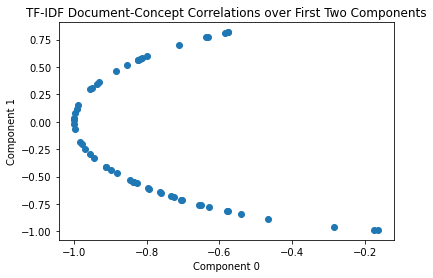

Populating the interactive namespace from numpy and matplotlib


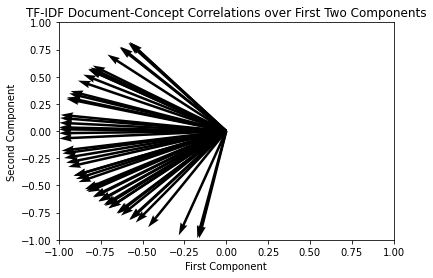

In [ ]:
reader.graph()

In [ ]:
# print(reader.dictionary)
reader.test(5)

In [ ]:
reader.n_docs

55

In [ ]:
reader.n_queries

25

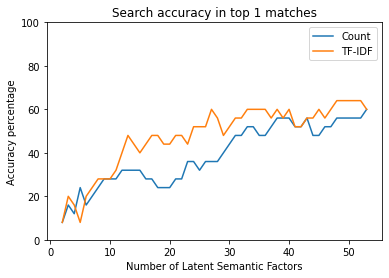

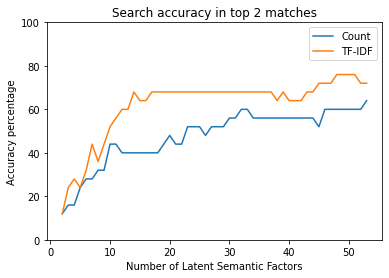

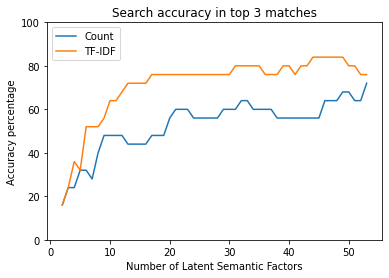

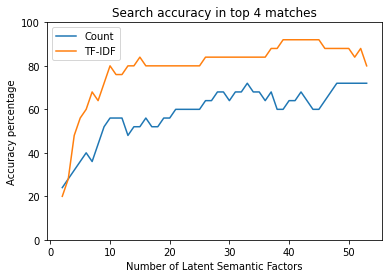

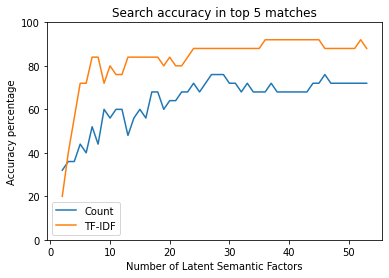

In [ ]:
results_cv = [[],[],[],[],[]]
results_tv = [[],[],[],[],[]]
a = 54
for n in range (1, 6):
  results_cv[n-1].append(NaN)
  results_cv[n-1].append(NaN)
  results_tv[n-1].append(NaN)
  results_tv[n-1].append(NaN)
  for k in range(2, a):
    reader = DataReader()
    reader.train(k, False)
    reader.test(n)
    results_cv[n-1].append(reader.score()*100)
    reader2 = DataReader()
    reader2.train(k, True)
    reader2.test(n)
    results_tv[n-1].append(reader2.score()*100)
  chart = pd.DataFrame.from_dict({'Count': results_cv[n-1], 'TF-IDF': results_tv[n-1]})
  fig = chart.plot(xlabel='Number of Latent Semantic Factors', ylabel='Accuracy percentage', title=f'Search accuracy in top {n} matches', ylim=(0, 100)).get_figure()
  
  fig.savefig(f'plot{n}-{a}.png')

# print(results_cv)
# print(results_tv)